# Faster RCNN ResNet50 without custom classes

This is an implementation showing the usage of pytorch's fasterrcnn module

(no transfer learning, simply recognizing coco class instances)

[Documentation](https://pytorch.org/docs/stable/torchvision/models.html#faster-r-cnn)

In [10]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torchvision
from torchvision import transforms

In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)
model.eval()

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [13]:
def get_prediction(img_path, threshold):

    img = Image.open(img_path)
    # preprocess image using pytorch's transforms
    # no training, thus only convert to tensor
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img)
    # put image in model, get detections
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())

    try:

        pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
        pred_boxes = pred_boxes[:pred_t+1]
        pred_class = pred_class[:pred_t+1]

        return pred_boxes, pred_class

    except IndexError as ie:
    
        print(f'Sorry, no objects were detected that suit the threshold {threshold}')

        return [], []

In [14]:
def object_detection(img_path, threshold=0.5):
    
    boxes, pred_cls = get_prediction(img_path, threshold)
    COLORS = np.random.randint(0, 256, size=(len(np.unique(pred_cls)), 3),
                               dtype="uint8")
    pred_dict = dict(zip(np.unique(pred_cls), COLORS))

    # re-read using opencv to mark predictions
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # draw predictions on image
    for i in range(len(boxes)):
    
        color = tuple(int(c) for c in pred_dict[pred_cls[i]])
        cv2.rectangle(img, boxes[i][0], boxes[i][1], color, thickness=3)
    
    # display image + predictions
    plt.figure(figsize=(10,20))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    # show predicted classes in legend instead of next to rectangles
    markers = [plt.Line2D([0,0],[0,0],color=color/255, marker='o', linestyle='') for color in pred_dict.values()]
    plt.legend(markers, pred_dict.keys(), numpoints=1)
    plt.show()

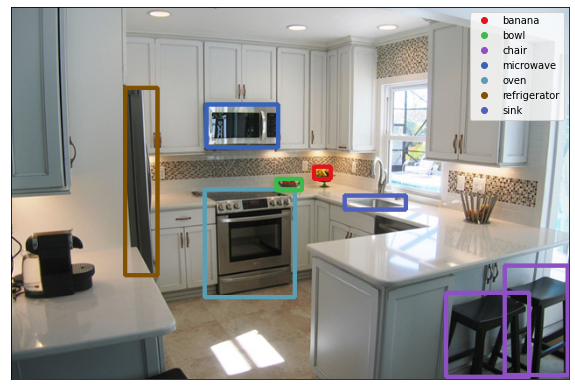

In [15]:
object_detection('/Users/natalie/Downloads/iu.jpeg', threshold=0.7)